In [1]:
%matplotlib notebook
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob

from scipy import ndimage
from scipy.signal import convolve2d, gaussian

import MosaicFitsReader as mfr
import FindSources as fs

sys.path.append("../../libs/")
import HEq

In [3]:
def findBestFocus(focus, fwhm, defFocus):
    """
    Fits a hyperbola: x=focus, y=fwhm
    Hyperbola equation: y^2 = Ax^2 + Bx + C
    Returns bestFocus or defFocus if data does not fit a hyperbola or less than 5 samples
    """
    select = np.where(np.array(fwhm) > 0)
    if select[0].shape[0] < 5:
        return defFocus
    focus1 = np.array(focus)[select]
    fwhm1 = np.array(fwhm)[select]
    
    res = np.polyfit(focus1, np.multiply(fwhm1, fwhm1), deg=2)

    A, B, C = res
    if A <= 0:
        return defFocus
    minX = -B/2/A
    return minX

In [4]:
def genMesh(roi, cellSize):
    """
    Generates a regular mesh for given cellSize
    The mesh is (XX, YY) where XX and YY are 2D arrays of coordinates.
    """
    args = []
    x0, y0, x1, y1 = roi
    #print ("width {0}, height {1}".format(width, height))
    half = cellSize//2
    xs = range(x0, x1, cellSize)
    ys = range(y0, y1, cellSize)
    #print(xs, ys)
    return np.meshgrid(xs, ys)

def init2DArray(xs):
    """
    Creates a 2D array of same shape as xs
    """
    return[ [ [] for m in n ] for n in xs]

def findFWHMs (img, mesh, fwhms, cellSize=90):
    """
    Given an image, finds centroids at the coordinates specified by the mesh.
    """
    def isInBox (xc, yc, x0, y0, x1, y1):
        return (x0<=xc) and (xc<x1) and (y0<=yc) and (yc<y1)

    fc = fs.FindSources(img, minContrast=0)
    xs, ys = mesh
    rows, cols = len(xs), len(xs[0])
    half = cellSize//2
    for i, j, k in zip (*mesh, fwhms):
        for x, y, f in zip (i, j, k):
            x0, y0 = x-half, y-half
            x1, y1 = x0 + cellSize, y0 + cellSize
            centroid = fc.centroid2D(x0, y0, x1, y1, 0.9, 1E-3)
            xc, yc, fwhm, ct, dist, n = centroid
            if fwhm <= 0 or ct <= 0 or fwhm > 12:
                fwhm = 0
            f.append(fwhm)


In [5]:
def balanceDeimos (img, regInfo):
    """
    Adds a delta to the regions such that the average levels are the same
    Returns a new image
    """
    imgOut = np.copy(img)
    height = img.shape[0]
    midRow = height//2
    medianValue = np.median(img[midRow,:])
    #print ("Row %d, value %d" % (midRow, medianValue))
    regValues = []
    for x0,x1,y0,y1 in regInfo:
        x0 = x0-1
        currVal = np.median(img[midRow,x0:x1])
        dVal = currVal - medianValue
        imgOut[:,x0:x1] = img[:,x0:x1] - dVal
        regValues.append(currVal)
    
    #print (regValues)
    return imgOut
    

In [6]:
def cleanup (bImg):
    """
    Overwrites columns that are not clean
    """
    bImg[:,1052:1054]= np.median(bImg[:,1051])
    bImg[:,2424:2428]= np.median(bImg[:,2322])
    bImg[:,6142:6150]= np.median(bImg[:,6152])
    bImg[:,6191:6193]= np.median(bImg[:,6194])
    bImg[:,6886:6890]= np.median(bImg[:,6885])
    bImg[:,7140:7143]= np.median(bImg[:,7138])
    return bImg
        
def processSet (flist, mesh, cellSize, result=0):
    """
    For given file list, finds fwhm at coordinates given by mesh.
    Returns the DWFOCVAL for each file and the fwhms in a 2D array.
    """
    xs, ys = mesh
    fwhmBuf2D = init2DArray(xs)
    print ("len", len(fwhmBuf2D), len(fwhmBuf2D[0]))
    focus = []
    for f in flist:
        print ("processing", f)
        ffile = mfr.MosaicFitsReader(f)
        bImg = balanceDeimos(ffile.data, ffile.info)
        cleanup(bImg)
        findFWHMs(bImg, mesh, fwhmBuf2D, cellSize)
        focus.append(ffile.getKeyword("DWFOCVAL"))
    return focus, fwhmBuf2D

def calcBestFocusAll (focus, fwhm2D):
    """
    Finds the best focus at each cell in fwhm2D
    Returns a 2D array of best focuses.
    """
    out = []
    meanFocus = np.mean(focus)
    for row in fwhm2D:
        outRow = []
        for fwhms in row:
            bestFocus = findBestFocus(focus, fwhms, defFocus=meanFocus)
            outRow.append(bestFocus)
        out.append(outRow)
    return out

def cleanColum (bestFocus, colList):
    """
    Cleans up a colunm by replacing the value by the average of the neighbor columns.
    """
    for idx in colList:
        for row in bestFocus:
            row[idx] = (row[idx-1] + row[idx+1])/2
            
def copyColum (bestFocus, idx, fromIdx):
    """
    Cleans up a column by replacing the value by the give column
    """
    for row in bestFocus:
        row[idx] = row[fromIdx]

def printAll (mesh, bestFocus, fwhm2D):
    """
    Prints the best focus values and the measured fwhms in fwhm2D.
    """
    xx, yy = mesh
    for j, row in enumerate(fwhm2D):
        for i, fwhms in enumerate(row):
            if np.mean(fwhms) != 0:
                print (xx[j,i], yy[j,i], bestFocus[j][i], ",".join( ("%.2f" % f) for f in fwhms ))

In [7]:
""" 
Main section
"""

roi = 30, 1340, 8140, 3900
gridSize = 100
mesh = genMesh(roi, gridSize)

#prefix = "data/d1115_%04d.fits"
#fileList = [ (prefix % (d)) for d in range(4, 11) ]

prefix = "/h/observing/miraArchive/k2/17/11/13/deimos/*.fits.gz"

fileList = glob.glob(prefix)
focus, fwhm2D = processSet(fileList, mesh, gridSize)            


len 26 82
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.09005.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08821.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08154.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08228.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08882.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08698.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08760.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08305.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.09067.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08943.fits.gz
processing /h/observing/miraArchive/k2/17/11/13/deimos/DE.20171113.08078.fits.gz


In [8]:
bestFocus = calcBestFocusAll(focus, fwhm2D)

In [9]:
cleanColum(bestFocus, (10,41,71))
copyColum(bestFocus, 61, 60)
copyColum(bestFocus, 62, 63)

In [68]:
printAll(mesh, bestFocus, fwhm2D)

1030 1340 -8867.18395759 11.81,0.00,0.00,0.00,11.75,0.00,11.73
1130 1340 -9729.22505803 11.87,11.44,11.07,10.88,10.47,10.54,10.75
1230 1340 -9722.1731455 0.00,11.65,11.30,11.12,11.07,11.17,11.05
1330 1340 -9161.56003504 0.00,11.79,11.46,10.99,10.94,11.04,11.25
1430 1340 -10124.4117757 0.00,0.00,11.76,11.55,11.49,11.25,11.43
1530 1340 -8005.14285714 0.00,0.00,0.00,11.94,11.83,11.83,11.94
1830 1340 -8005.14285714 7.93,6.98,0.00,0.00,0.00,0.00,0.00
1930 1340 -8005.14285714 0.00,6.86,6.01,5.39,0.00,0.00,0.00
2030 1340 -9087.92907477 0.00,6.86,5.37,4.91,4.74,4.88,5.43
2130 1340 -9081.12737651 7.06,6.16,5.37,4.91,0.00,4.88,5.30
2230 1340 -8951.46037882 6.75,5.94,5.23,4.73,4.57,4.74,5.30
2330 1340 -9045.68591513 6.77,5.91,5.20,4.72,4.57,4.72,5.15
2430 1340 -9222.51905566 6.78,5.98,5.20,4.70,4.45,4.58,0.00
2530 1340 -9306.80072117 6.85,6.01,5.25,4.68,4.51,4.53,4.90
2630 1340 -9369.4320808 6.85,6.05,5.27,4.72,4.47,4.52,4.87
2730 1340 -9360.98421823 6.82,5.96,5.22,4.67,4.39,4.44,4.81
5430 1340 -

7830 2540 -8781.3569128 6.63,5.41,4.43,3.68,3.62,3.92,4.85
7930 2540 -9048.98513119 6.67,5.79,4.90,4.12,3.82,3.95,4.85
8030 2540 -9382.61080384 6.67,5.79,4.90,4.12,3.82,3.95,4.35
30 2640 -8450.08654694 6.96,5.98,5.24,4.88,4.85,5.33,6.08
130 2640 -8442.41334628 7.03,6.00,5.27,4.86,4.88,5.34,6.13
230 2640 -8452.26818175 7.01,6.02,5.24,4.88,4.84,5.27,6.13
330 2640 -8457.42385289 6.99,6.04,5.24,4.86,4.85,5.39,6.07
430 2640 -8411.54570769 6.93,5.98,5.21,4.81,4.86,5.35,6.12
530 2640 -8345.63061966 6.86,5.91,5.15,4.81,4.87,5.34,6.20
630 2640 -8291.98335494 6.76,5.83,5.14,4.69,4.82,5.34,6.21
730 2640 -8226.60402002 6.63,5.72,5.01,4.64,4.80,5.36,6.19
830 2640 -8158.99981322 6.58,5.64,4.97,4.63,4.78,5.40,6.27
930 2640 -8092.66942543 6.48,5.52,4.86,4.58,4.72,5.35,6.32
1030 2640 -8063.38925029 5.86,5.44,5.46,4.96,4.98,5.27,5.97
1130 2640 -8034.10907515 6.31,5.44,4.72,4.48,4.70,5.32,6.29
1230 2640 -8004.02082124 6.25,5.41,4.71,4.46,4.66,5.32,6.31
1330 2640 -7972.57556543 6.24,5.32,4.68,4.42,4.69,5.

4230 3440 -7933.02156479 5.85,4.91,4.37,4.09,4.38,5.02,6.01
4330 3440 -7958.94254675 5.86,4.94,4.33,4.10,4.34,5.00,5.97
4430 3440 -7965.04532428 5.86,4.97,4.24,4.08,4.35,4.99,5.94
4530 3440 -7976.04132 5.84,4.92,4.29,4.07,4.34,4.95,5.90
4630 3440 -8014.38368965 5.85,4.93,4.27,3.99,4.25,4.90,5.84
4730 3440 -8011.67262937 5.84,4.92,4.24,4.00,4.25,4.89,5.83
4830 3440 -8016.74730152 5.91,4.98,4.38,4.08,4.35,4.96,5.90
4930 3440 -7972.76197277 5.90,5.01,4.35,4.17,4.42,5.03,5.97
5030 3440 -7974.33205254 5.77,4.96,4.26,4.05,4.32,4.95,5.86
5130 3440 -7984.64297711 5.81,4.94,4.27,4.04,4.34,4.94,5.85
5230 3440 -8009.85417097 5.78,4.83,4.19,3.90,4.23,4.80,5.77
5330 3440 -8032.88495083 5.68,4.71,3.99,3.69,4.07,4.63,5.61
5430 3440 -7990.89174431 5.62,4.62,3.93,3.64,4.00,4.64,5.64
5530 3440 -7974.26742037 5.56,4.59,3.90,3.60,3.98,4.60,5.63
5630 3440 -7965.39996143 5.53,4.56,3.86,3.58,3.97,4.58,5.62
5730 3440 -7943.41737431 5.47,4.52,3.85,3.53,3.95,4.59,5.61
5830 3440 -7927.31224541 5.49,4.51,3.80,3.5

<IPython.core.display.Javascript object>


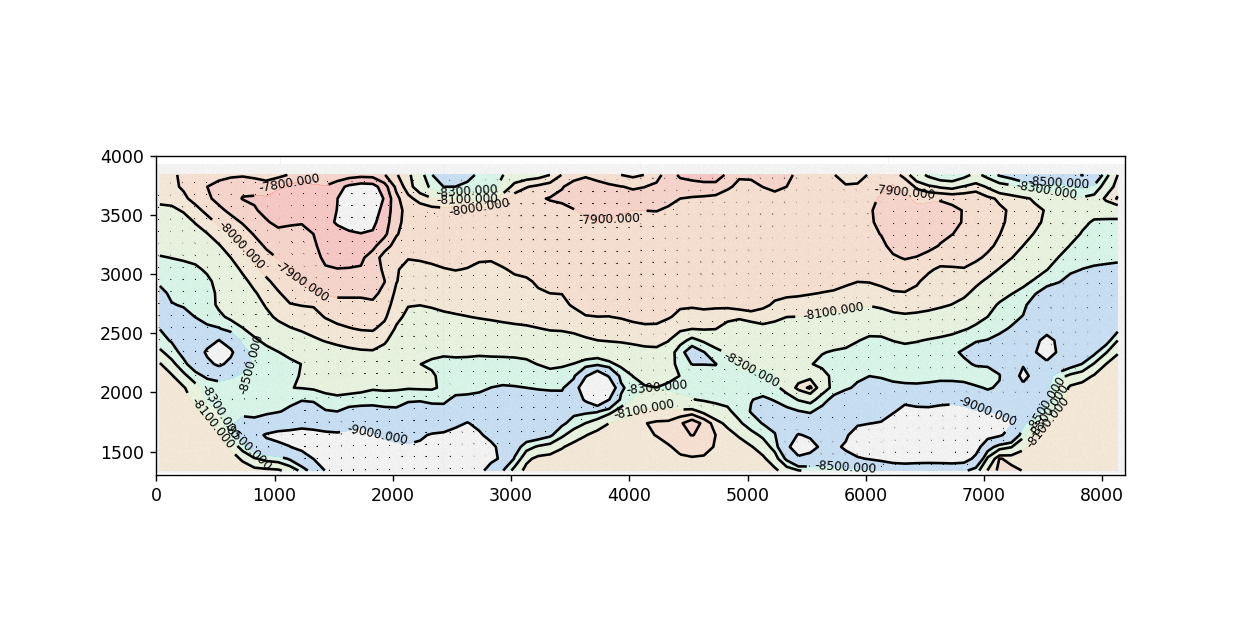

(1300, 4000)

In [10]:
plt.figure(figsize=(10,5))
ffile = mfr.MosaicFitsReader(fileList[0])
cleanup(ffile.data)
bImg = balanceDeimos(ffile.data, ffile.info)
plt.imshow(HEq.hEqC(bImg), cmap='gray_r', origin='lower')
mustSmooth = True
if mustSmooth:
    smoothed = ndimage.filters.gaussian_filter(bestFocus, 0.9)
else:
    smoothed = bestFocus
levels = -9000, -8500, -8300, -8100, -8000, -7900, -7800, -7700

plt.contourf(mesh[0], mesh[1], smoothed, levels, alpha=0.2, cmap='rainbow')
ctr = plt.contour(mesh[0], mesh[1], smoothed, levels, colors='k', linestyles='-')

plt.clabel(ctr, fontsize=7, inline=1)
plt.ylim(1300, 4000)
#plt.colorbar()

<IPython.core.display.Javascript object>


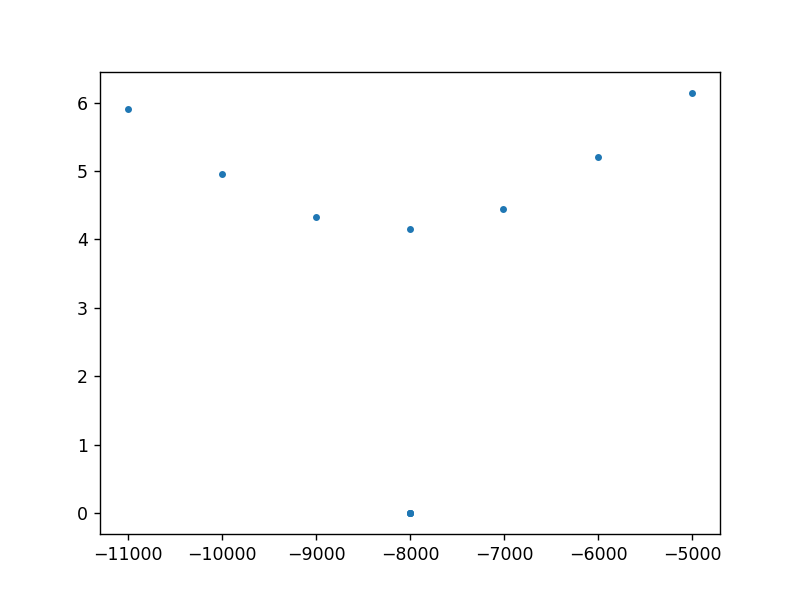

In [12]:
def plot2Curve(xIdx, yIdx, focus, fwhm2D):
    fwhms = fwhm2D[yIdx][xIdx]
    plt.figure()
    plt.plot(focus, fwhms, '.')
    
plot2Curve(40, 10, focus, fwhm2D)

In [13]:
# Test one file
FileName = "data/d1115_0006.fits"

ffile = mfr.MosaicFitsReader(FileName)
bImg = balanceDeimos(ffile.data, ffile.info) 

<IPython.core.display.Javascript object>


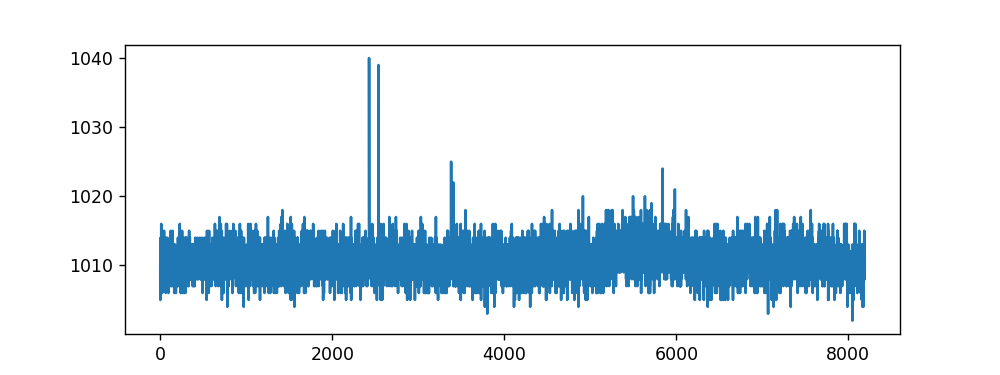

In [14]:
plt.figure(figsize=(8,3))
img1=cleanup(bImg)
#bImg[:, 2424:2428] = 1009
#plt.plot(np.sum(bImg, axis=0), '.-')
plt.plot(img1[3230,:])
#plt.ylim(900, 1100)

In [62]:
np.median(bImg[:,242])

1009.0

In [17]:
26*82

2132